In [1]:
import hddCRP.simulations
import hddCRP.modelFittingSequential
import hddCRP.behaviorDataHandlers
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import seaborn as sns

In [2]:
results_directory = "Results/Simulations"
if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)
    
simulation_id = 0; # for naming file

overwrite_existing_results = True

run_range = range(0,1)

num_warmup_samples =5000
num_samples = 5000

initialize_fit_with_real_connections = False;

prior_scales = None
prior_shapes = None

if(simulation_id == 0):
    depth  = 1; # look 2 actions in the past
    alphas = [5] # concentration parameters: per depth in the hddCRP tree. alphas[0] first level (no action context), alphas[1] is the second (for regularizing p(y_t | y_{t-1})), etc...
    between_session_time_constants = np.array([[ 1]]) # units = sessions
    within_session_time_constant = [40] # units = actions
    session_length = lambda run_idx, block_idx : 50*block_idx # trials per session
    num_sessions   = lambda run_idx, block_idx : 1 # trials per session

    action_labels = [0,1,2] 
    maze_symbols = ['A']
    uniform_prior = False
    min_blocks_per_type = 1
    max_blocks_per_type = 10;
    prior_scales = {"alpha" : 10, "tau_within" : 25, "tau_between" : 10}
    prior_shapes = {"alpha" : 2, "tau_within" :  2, "tau_between" : 2}


block_range = range(min_blocks_per_type, max_blocks_per_type)

true_parameters = {}
alpha_strs = ["no", "one_back", "two_back", "three_back"]
for dd in range(depth):
    true_parameters["alpha_concentration_" + alpha_strs[dd] + "_context"] = alphas[dd]
for aa_i, aa in enumerate(maze_symbols): 
    true_parameters["within_session_" + aa + "_time_constant"] = within_session_time_constant[aa_i]

if(max_blocks_per_type > 1):
    for aa_i, aa in enumerate(maze_symbols):
        for bb_i, bb in enumerate(maze_symbols[aa_i:]):
            true_parameters[aa + "_to_" + bb + "_session_time_constant"] = between_session_time_constants[aa_i,bb_i]

In [ ]:
for run_idx in run_range:
    for block_idx in block_range:
        filename = "{results_directory}/Sim_{sim_num}_size_{N_blocks_per_type}_run_{run_idx}.pkl".format(results_directory=results_directory, sim_num=simulation_id, N_blocks_per_type=block_idx, run_idx=run_idx)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            rng_seed_sim = 100 + 10000*run_idx;
            rng_seed_fit = 200 + 10000*run_idx;
            rng_sim = np.random.Generator(np.random.MT19937(rng_seed_sim))
            rng_fit = np.random.Generator(np.random.MT19937(rng_seed_fit))


            session_lengths = [session_length(run_idx, block_idx)] * (len(maze_symbols) * num_sessions(run_idx, block_idx))
            session_labels = [];
            for aa in maze_symbols:
                session_labels += [aa] * num_sessions(run_idx, block_idx)  # which maze

            seqs, connection_data = hddCRP.simulations.simulate_sequential_hddCRP(session_lengths, session_labels, action_labels, depth, rng_sim, alphas, 
                    between_session_time_constants = between_session_time_constants, within_session_time_constant = within_session_time_constant)

            simulation_info = {"rng_seed_simulation" : rng_seed_sim, "rng_seed_fitting" : rng_seed_fit, "rng_type" : "MT19937",
                            "session_lengths" : session_lengths, "session_labels" : session_labels, "action_labels" : action_labels,
                            "seqs" : seqs, "connection_data" : connection_data}

            model = hddCRP.simulations.create_hddCRPModel_from_simulated_sequential_hddCRP(seqs, connection_data, rng=rng_fit, use_real_parameters=initialize_fit_with_real_connections)
            
            tau_names = [str(xx) for xx in model.weight_param_labels]
            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            model, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_model_for_maze_data(model, num_samples=num_samples, 
                            num_warmup_samples=num_warmup_samples, print_every=2500, uniform_prior=uniform_prior, prior_shapes=prior_shapes, prior_scales=prior_scales)

            MCMC_info = {"initialized_with_true_connections" : initialize_fit_with_real_connections,
                        "step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples,
                        "uniform_prior" : uniform_prior}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names[:depth]
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"true_parameters" : true_parameters,
                                "simulation_info" : simulation_info,
                                "MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)


In [ ]:
empty_data = np.zeros((num_samples, len(run_range)*len(true_parameters)*(max_blocks_per_type-1)))
empty_data.fill(np.nan)
parameters = pd.DataFrame(empty_data,
                  columns=pd.MultiIndex.from_product([true_parameters.keys(), range(min_blocks_per_type,max_blocks_per_type+1), run_range], names=["parameter", "sessions per maze", "run"]))
parameters.index.name='sample'

# plot results: MCMC credible intervals for each parameter as a function of N_blocks_per_type
print("Metropolis-Hastings acceptance rate and step size:")
for run_idx, run_num in enumerate(run_range):
    for N_blocks_per_type in range(min_blocks_per_type,max_blocks_per_type+1):
        filename = "{results_directory}/Sim_{sim_num}_size_{N_blocks_per_type}_run_{run_num}.pkl".format(results_directory=results_directory, sim_num=simulation_id, N_blocks_per_type=N_blocks_per_type, run_num=run_num)
        if(not os.path.isfile(filename)):
            raise RuntimeError("Results file not found: " + filename)
            # throw error
        
        # load file
        with open(filename, "rb") as results_file:
            results = pickle.load(results_file)

            '''
            Make sure all the files loaded are correct
            '''

            # check for correct results fields
            expected_fields = ["true_parameters", "simulation_info", "MCMC_info", "samples"]
            if(not isinstance(results, dict) or not np.all(np.isin(expected_fields, list(results.keys())))):
                raise ValueError("File " + filename + " does not contain expected results fields")
            
            session_lengths = [session_length(run_idx)] * (len(maze_symbols) * N_blocks_per_type)
            session_labels = [];
            for aa in maze_symbols:
                session_labels += [aa] * N_blocks_per_type  # which maze
            if(results["simulation_info"]["session_lengths"] != session_lengths):
                raise ValueError("File " + filename + " does not contain expected session lengths")
            if(results["simulation_info"]["session_labels"] != session_labels):
                raise ValueError("File " + filename + " does not contain expected session labels")
            if(results["simulation_info"]["action_labels"] != action_labels):
                raise ValueError("File " + filename + " does not contain expected action labels")


            #results["samples"]["alphas_names"] = results["samples"]["alphas_names"][:depth]

            # check if samples matches (if greater than expected, raise a warning; it less, raise an error)
            expected_fields_samples = ["log_taus", "alphas", "accepted", "num_warmup_samples", "tau_parameter_names", "alphas_names"]
            if(not isinstance(results["samples"], dict) or not np.all(np.isin(expected_fields_samples, list(results["samples"].keys())))):
                raise ValueError("File " + filename + " does not contain expected results['samples'] fields")
            
            num_samples_found = min(results["samples"]["log_taus"].shape[0], results["samples"]["alphas"].shape[0]) - results["samples"]["num_warmup_samples"]
            if(num_samples_found < num_samples):
                raise ValueError("File " + filename + " does not contain expected number of samples in results['samples']. Found " + str(num_samples_found) + ". Expected " + str(num_samples) + ".")

            # check if true params match, if not, raise error
            if(not np.all(np.isin(list(true_parameters.keys()), results["samples"]["tau_parameter_names"] + results["samples"]["alphas_names"]))):
                raise ValueError("File " + filename + " does not contain expected parameters in results['samples']")
            if(not np.all(np.isin(list(true_parameters.keys()), list(results["true_parameters"].keys()))) or not np.all(np.isin(list(results["true_parameters"].keys()), list(true_parameters.keys())))):
               raise ValueError("File " + filename + " does not contain expected parameters in results['true_parameters']")
            
            for p_name in true_parameters.keys():
               if(true_parameters[p_name] != results["true_parameters"][p_name]):
                   raise ValueError("File " + filename + " does not contain expected parameter value results['true_parameters'][" + p_name + "]")

            # load samples from each parameter into dataframe (multi-index: name of param and run number)
            s_index = range(results["samples"]["num_warmup_samples"], results["samples"]["num_warmup_samples"] + num_samples)
            for ii, p_name in enumerate(results["samples"]["tau_parameter_names"] ):
                
                parameters.loc[:,(p_name,N_blocks_per_type,run_idx)] = np.exp(results["samples"]["log_taus"][s_index,ii])
            for ii, p_name in enumerate(results["samples"]["alphas_names"] ):
                parameters.loc[:,(p_name,N_blocks_per_type,run_idx)] = results["samples"]["alphas"][s_index,ii]

            print("Run " + str(run_idx) + ", num blocks " + str(N_blocks_per_type) + ": rate = " + str(np.mean(results["samples"]["accepted"][s_index])) + ", step size = " + str(np.sqrt(results["MCMC_info"]["step_size_settings"]["step_size_fixed"])))


In [ ]:
parameters_s = parameters.stack([1,2]).reset_index()    
n_cols = 2
n_rows = int(np.ceil(len(true_parameters)/float(n_cols)))
plt.figure(figsize=(n_cols*8,n_rows*4))

for ii, p_name in enumerate(true_parameters.keys()):
    plt.subplot(n_rows, n_cols, ii+1)
    # for each parameter in the data frame, make a plot of 95% CI and mean over time vs. true params
    pp = sns.lineplot(x="sessions per maze", y=p_name,
                hue="run", errorbar=("pi",95),
                data=parameters_s)
    plt.plot([min_blocks_per_type,max_blocks_per_type], [true_parameters[p_name], true_parameters[p_name]], "k:")
    pp.set_xticks(range(min_blocks_per_type,max_blocks_per_type+1))

In [18]:
#plt.plot(np.array(parameters["within_session_time_constant"][2][0]))
depth = 1;
alphas = [10] * depth
run_idx = 1;
block_idx = 1;
# rng_seed_sim = 100 + 10000*run_idx;
# rng_seed_fit = 200 + 10000*run_idx;
# rng_sim = np.random.Generator(np.random.MT19937(rng_seed_sim))
# rng_fit = np.random.Generator(np.random.MT19937(rng_seed_fit))
within_session_time_constant = [40]


session_lengths = [500]
session_labels = ['A'];

seqs, connection_data = hddCRP.simulations.simulate_sequential_hddCRP(session_lengths, session_labels, action_labels, depth, rng_sim, alphas, 
        between_session_time_constants = between_session_time_constants, within_session_time_constant = within_session_time_constant)
model = hddCRP.simulations.create_hddCRPModel_from_simulated_sequential_hddCRP(seqs, connection_data, rng=rng_fit, use_real_parameters=initialize_fit_with_real_connections)

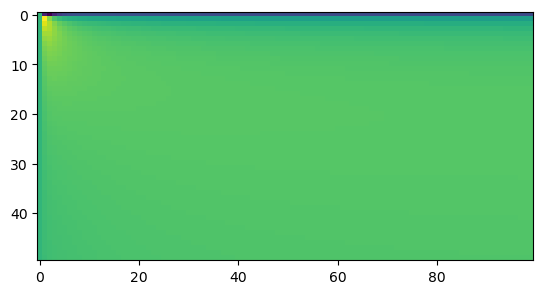

In [12]:

aas = np.arange(0.1,50,1)
tts = np.arange(0.1,100,1)

L = np.zeros((aas.size,tts.size))
for ii, aa in enumerate(aas):
    for jj, tt in enumerate(tts):
        model.weight_params = [np.log(tt)]
        model.alpha = [aa]

        L[ii,jj] = model.compute_log_likelihood()  
# 
plt.imshow(L);

In [19]:


model, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_model_for_maze_data(model, num_samples=200, 
                num_warmup_samples=200, print_every=100, uniform_prior=uniform_prior, prior_shapes=prior_shapes, prior_scales=prior_scales, single_concentration_parameter=True)


Sample 0 / 400
Sample 100 / 400
Sample 200 / 400
Sample 300 / 400


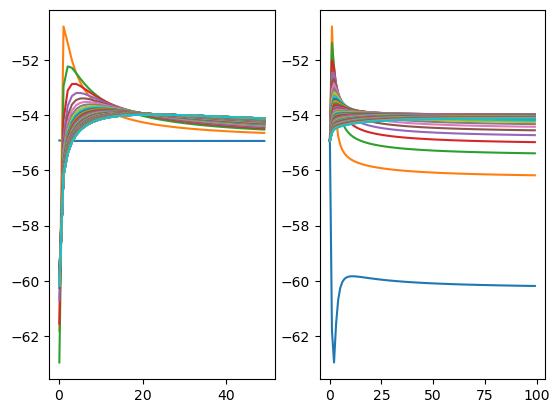

In [13]:

plt.subplot(1,2,1)
plt.plot(aas,L);
plt.subplot(1,2,2)
plt.plot(tts,L.T);

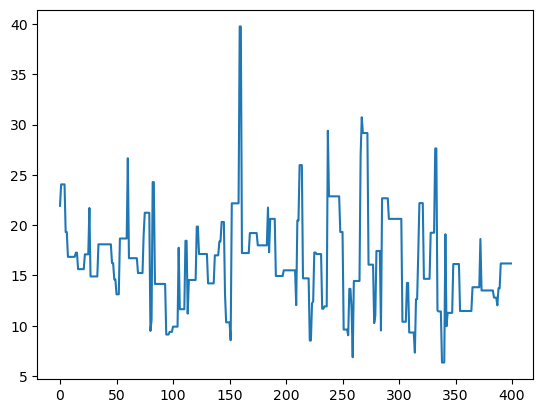

In [20]:
plt.plot(np.exp(samples["log_taus"]))

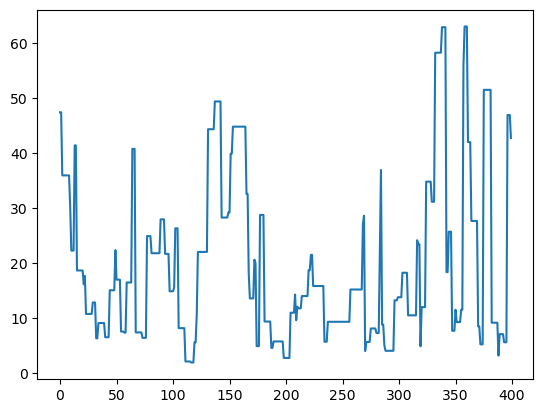

In [17]:
plt.plot(samples["alphas"])

In [7]:
connection_data["C_y"]

array([2, 1, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 2,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1,
       0, 2, 0, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 1, 2, 0,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 0, 0,
       2, 0, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 1,
       0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1,
       1, 2, 0, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 2])